## Imports

In [2]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test, plot_results

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the corresponsing csv, store the dataset to the DB, preprocess it, and get it as a pytorch graph object

In [4]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "tagline"],
    list_features=[],
    fastRP_features=["fastRP_genres", "fastRP_keywords"],
)
data = dataset[0].to(device)

Processing...


Encoding title...


Batches: 100%|██████████| 284/284 [00:07<00:00, 37.37it/s]


Encoding tagline...


Batches: 100%|██████████| 284/284 [00:12<00:00, 22.99it/s]


Encoding ['fastRP_genres', 'fastRP_keywords']...
[torch.Size([9067, 384]), torch.Size([9067, 384]), torch.Size([9067, 32])]


Done!


#### Preprocess the dataset

In [5]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model

In [6]:
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=6,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=8,
    hidden_channels=16,
    out_channels=16,
).to(device)
losses = train_test(
    model=model,
    epochs=1000,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    logging_step=10,
    lr=0.012,
)

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 010, Loss: 6.9729, Train: 1.8321, Val: 1.8157, Test: 1.8535
Epoch: 020, Loss: 6.3255, Train: 1.5087, Val: 1.4951, Test: 1.5317
Epoch: 030, Loss: 6.2617, Train: 1.5099, Val: 1.4933, Test: 1.5424
Epoch: 040, Loss: 6.0656, Train: 1.4476, Val: 1.4323, Test: 1.4742
Epoch: 050, Loss: 5.1393, Train: 1.2028, Val: 1.1748, Test: 1.2268
Epoch: 060, Loss: 4.4396, Train: 1.4024, Val: 1.4394, Test: 1.4189
Epoch: 070, Loss: 4.1460, Train: 1.3038, Val: 1.3113, Test: 1.3494
Epoch: 080, Loss: 4.0017, Train: 1.2754, Val: 1.3505, Test: 1.3534
Epoch: 090, Loss: 3.8547, Train: 1.2542, Val: 1.2689, Test: 1.2997
Epoch: 100, Loss: 3.6735, Train: 1.2155, Val: 1.2343, Test: 1.2620
Epoch: 110, Loss: 3.6171, Train: 1.4428, Val: 1.4855, Test: 1.5006
Epoch: 120, Loss: 3.6170, Train: 1.1415, Val: 1.1787, Test: 1.1992
Epoch: 130, Loss: 3.5497, Train: 1.3148, Val: 1.3581, Test: 1.3561
Epoch: 140, Loss: 3.6007, Train: 1.2259, Val: 1.2781, Test: 1.2754
Epoch: 150, Loss: 3.4287, Train: 1.1864, Val: 1.2443, Test: 1.

#### Visualize

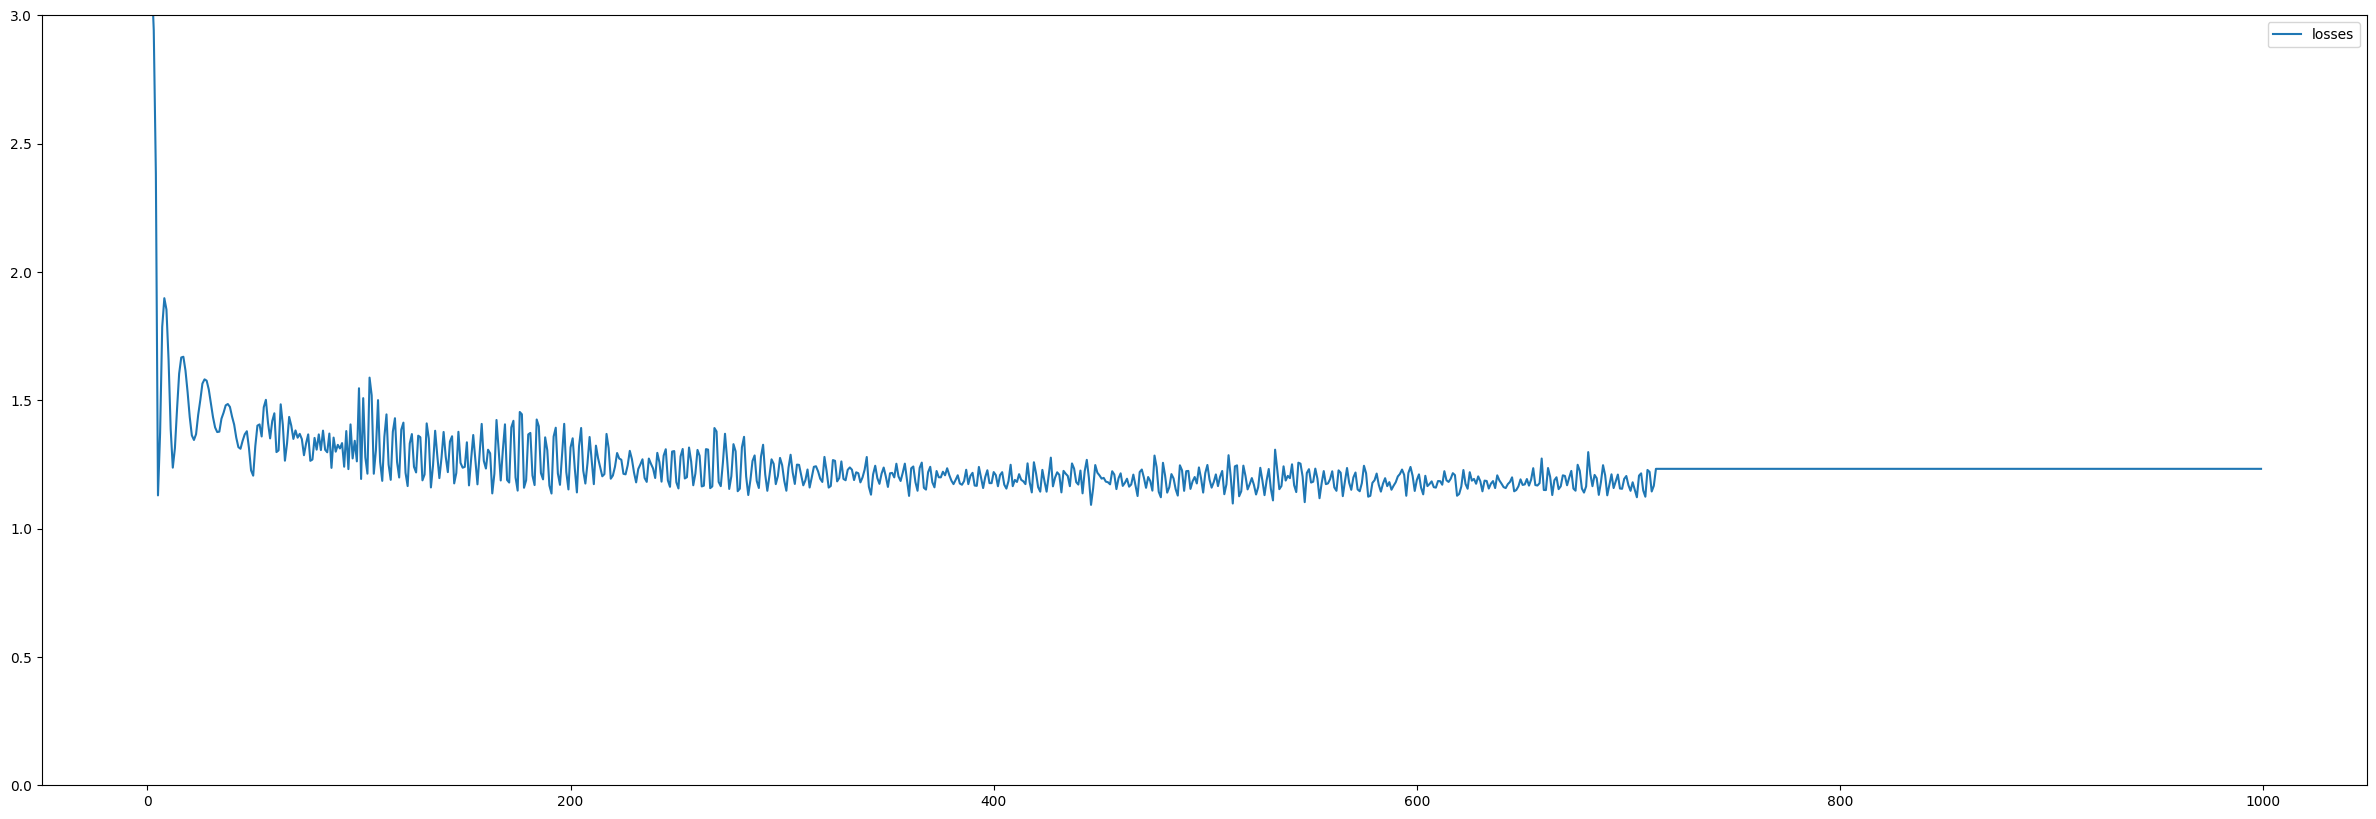

In [9]:
plot_test({ "losses": losses }, ylim=3)